In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
#load train data w/o running out of mem
chunk_size=10000
batch_no=1

for chunk in pd.read_csv('/kaggle/input/amex-default-prediction/train_data.csv',chunksize=chunk_size):
    chunk.to_csv('train'+str(batch_no)+'.csv',index=False)
    print(batch_no)
    batch_no+=1
    break

1


In [3]:
#alternative loading method
#dont use...

#chunk = pd.read_csv('/kaggle/input/amex-default-prediction/train_data.csv',chunksize=1000)
#df = pd.concat(chunk)
#df.head()

In [4]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/train1.csv
/kaggle/working/__notebook__.ipynb


In [5]:
df_label = pd.read_csv('/kaggle/input/amex-default-prediction/train_labels.csv')
df_label.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [6]:
#inspecting data
df1 = pd.read_csv('train1.csv')
df1.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827


In [7]:
#checking out data types
print(df1.dtypes.value_counts())
list(df1.select_dtypes(['object']).columns)

float64    185
object       4
int64        1
dtype: int64


['customer_ID', 'S_2', 'D_63', 'D_64']

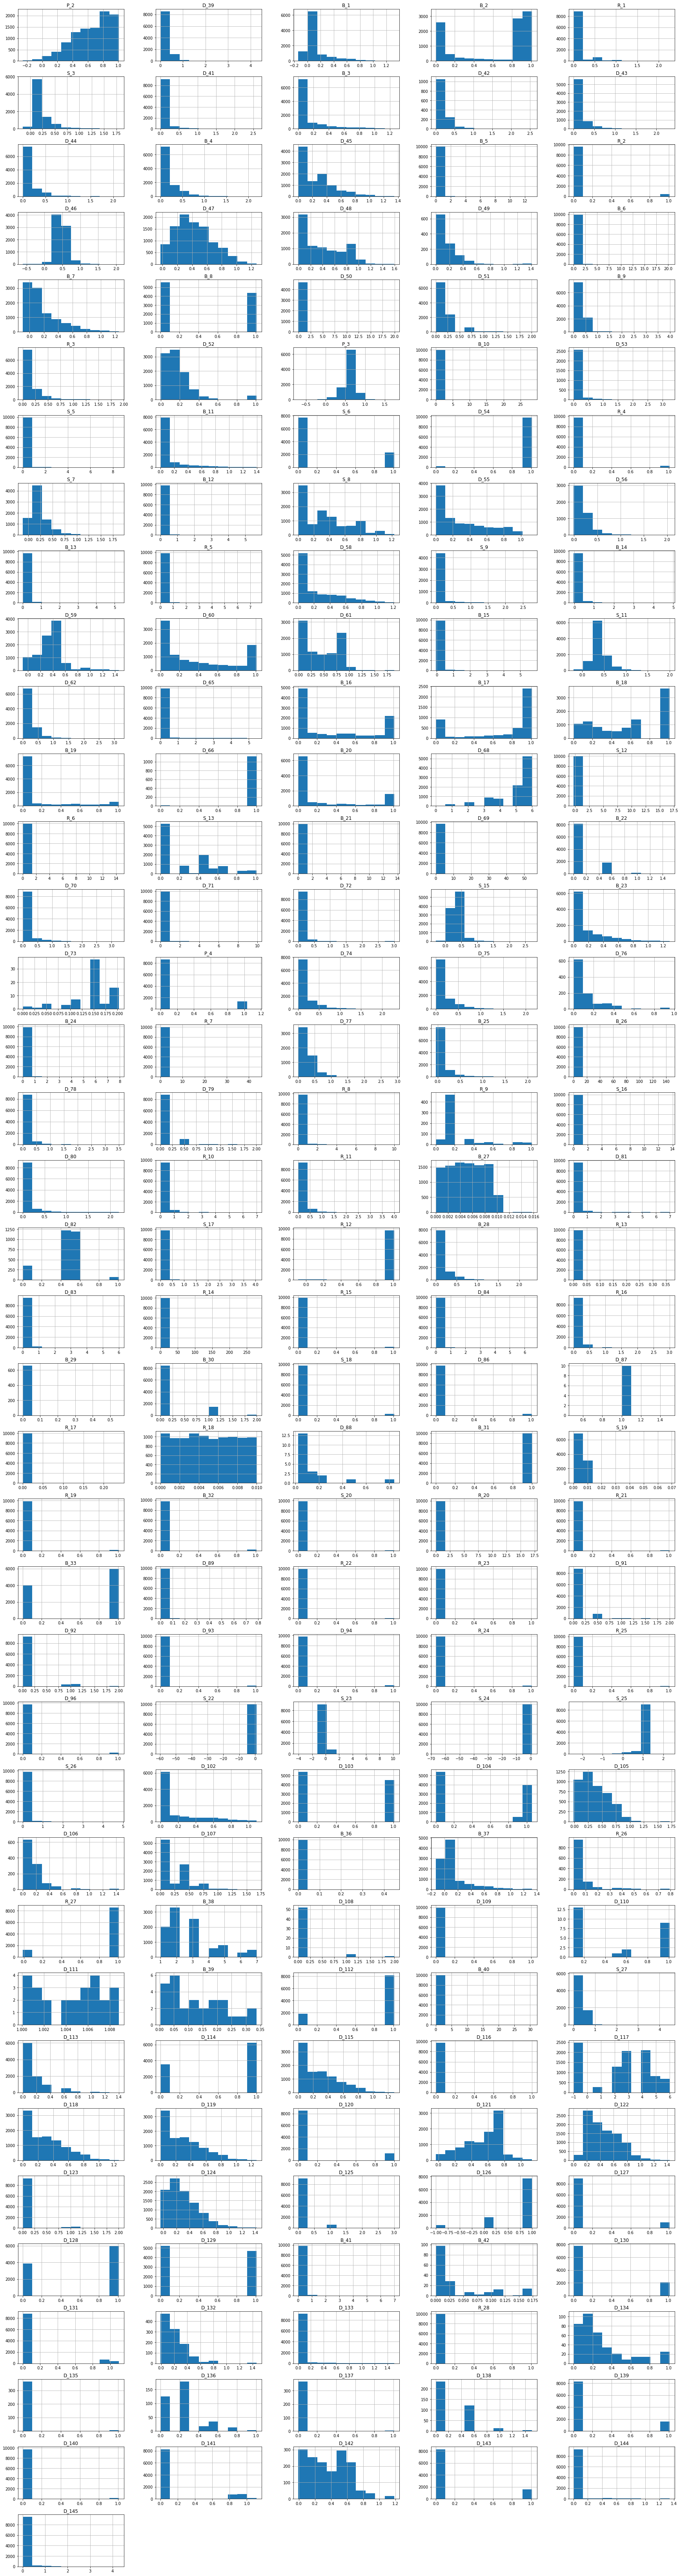

In [8]:
#visualizing columns

hist = df1.hist(bins=10, figsize = (30,120), layout=(-1,5) )

In [9]:
#df1.iloc[:100000,7].value_counts()
print(df1.iloc[:,1])


#What type of variable for dates
df1['S_2'] = pd.to_datetime(df1['S_2'])
df1['S_2'] = pd.to_numeric(df1['S_2'])
print(df1['S_2'])


#df1['S_2'] = pd.to_timedelta(df1['S_2'])
#print(df1.iloc[:,1].dt.total_seconds())

0       2017-03-09
1       2017-04-07
2       2017-05-28
3       2017-06-13
4       2017-07-16
           ...    
9995    2018-02-26
9996    2018-03-19
9997    2017-03-28
9998    2017-04-15
9999    2017-05-31
Name: S_2, Length: 10000, dtype: object
0       1489017600000000000
1       1491523200000000000
2       1495929600000000000
3       1497312000000000000
4       1500163200000000000
               ...         
9995    1519603200000000000
9996    1521417600000000000
9997    1490659200000000000
9998    1492214400000000000
9999    1496188800000000000
Name: S_2, Length: 10000, dtype: int64


In [10]:
df1 = pd.get_dummies(df1)

In [11]:
#inspecting NaN
print(df1.isnull().sum())
#df1.fillna(method ='ffill', inplace = True)

S_2         0
P_2        64
D_39        0
B_1         0
B_2         0
           ..
D_63_XZ     0
D_64_-1     0
D_64_O      0
D_64_R      0
D_64_U      0
Length: 1023, dtype: int64


In [12]:
#Handling missing values
my_imputer = SimpleImputer()
impd = my_imputer.fit_transform(df1.iloc[:,:190])
df1.iloc[:,:190] = impd

In [13]:
X = df1.iloc[:, :].values.reshape(-1, 1023)  # values converts it into a numpy array
Y = df_label.iloc[:10000, 1].values.reshape(-1, 1)
print('half')
log = LogisticRegression(class_weight='balanced')  # create object for the class
log.fit(X, Y)  # perform logistic regression
Y_pred = log.predict(X)

print(Y_pred, np.sum(Y_pred))
print(log.score(X, Y))

half
[1 1 1 ... 1 1 1] 10000
0.2649


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
